In [49]:
import numpy as np
import scipy.signal as signal
import pandas as pd
from wfdb import processing
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import os
from hrvanalysis import remove_outliers, remove_ectopic_beats, interpolate_nan_values, get_time_domain_features, get_frequency_domain_features

In [2]:
class ECGSignal():
    def __init__(self, ecg_signal, Fs=1000, lowcut=0.3, highcut=60, resample_fs=128):
        self.ecg_signal = ecg_signal
        self.Fs = Fs
        self.lowcut = lowcut
        self.highcut = highcut
        self.resample_fs = resample_fs

        self.filtered_ecg_signal = self.apply_filter_to_signal()
        self.resampled_ecg_signal = signal.resample(self.filtered_ecg_signal, (len(self.ecg_signal) // self.Fs) * self.resample_fs)

        self.conf = processing.XQRS.Conf(ref_period=0.4)
        self.xqrs = processing.XQRS(sig=ecg_signal, fs=Fs, conf=self.conf)
        self.xqrs.detect(learn=False)
        peaks = self.xqrs.qrs_inds / Fs
        self.RRI = np.diff(peaks)

    def get_rri(self):
        return self.RRI

    def butter_bandpass(self, order=4):
    # to gain paramaters of butterworth bandpass filter
        nyq = 0.5 * self.Fs
        low = self.lowcut / nyq
        high = self.highcut / nyq
        b, a = signal.butter(order, [low, high], btype='band')
        return b, a

    def apply_filter_to_signal(self, order=4):
    # apply butterworth bandpass filter to the signal
        b, a = self.butter_bandpass(order)
        filtered = signal.filtfilt(b, a, self.ecg_signal)
        return filtered

In [3]:
def csv_to_signal(filepath, header=None, skiprows=13):
    ecg_df = pd.read_table(filepath, header=header, skiprows=skiprows)[0]
    ecg_signal = ecg_df.values

    return ecg_signal

In [24]:
def preprocess_hrvanalysis(rri, low_rri=300, high_rri=2000, interpolation_method="linear", remove_method="malik"):
    rri_int = np.array(list(map(int, rri * 1000)))

    # This remove outliers from signal
    rr_intervals_without_outliers = remove_outliers(rr_intervals=rri_int,                                                     low_rri=low_rri, high_rri=high_rri)

    # This replace outliers nan values with linear interpolation
    interpolated_rr_intervals = interpolate_nan_values(rr_intervals=rr_intervals_without_outliers, interpolation_method=interpolation_method)

    # This remove ectopic beats from signal
    nn_intervals_list = remove_ectopic_beats(rr_intervals=interpolated_rr_intervals, method=remove_method)
    # This replace ectopic beats nan values with linear interpolation
    interpolated_nn_intervals = interpolate_nan_values(rr_intervals=nn_intervals_list)

    return rri_int, np.array(interpolated_rr_intervals), np.array(nn_intervals_list), np.array(interpolated_rr_intervals)

In [48]:
def calc_hrv_features(nn_intervals):
    time_domain_features = get_time_domain_features(nn_intervals)
    frequency_features = get_frequency_domain_features(nn_intervals)

    return time_domain_features, frequency_features

In [ ]:
filepath = '../data/WAV_00000010.txt'

Fs = 1000  # [Hz]

ecg_signal = ECGSignal(csv_to_signal(filepath))
rri = ecg_signal.get_rri()

rri_int, interpolated_rr_intervals, nn_intervals_list, interpolated_nn_intervals = preprocess_hrvanalysis(rri)

In [94]:
window = 50 * 1000
step = 10 * 1000
cumsum = np.nancumsum(interpolated_nn_intervals)
window_num = (int(cumsum[-1]) - window) // step + 1
timedomain = []
frequency = []

for w in range(window_num):
    start = w * step
    end = window + w * step
    windowed_rri = interpolated_nn_intervals[(start < cumsum) & (cumsum < end)]
    time_domain_features, frequency_features = calc_hrv_features(windowed_rri)
    timedomain.append(time_domain_features)
    frequency.append(frequency_features)


/home/bioinfo/.local/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 194, using nperseg = 194
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/bioinfo/.local/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 197, using nperseg = 197
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/bioinfo/.local/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 195, using nperseg = 195
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/bioinfo/.local/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 200, using nperseg = 200
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/bioinfo/.local/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarn

In [97]:
timedomain_df = pd.DataFrame([])
frequency_df = pd.DataFrame([])
timedomain_df = pd.concat([timedomain_df, pd.DataFrame.from_dict(timedomain)])
frequency_df = pd.concat([frequency_df, pd.DataFrame.from_dict(frequency)])


In [98]:
timedomain_df.head()

,mean_nni,sdnn,sdsd,nni_50,pnni_50,nni_20,pnni_20,rmssd,median_nni,range_nni,cvsd,cvnni,mean_hr,max_hr,min_hr,std_hr
0,946.730769,32.835965,33.749513,8,15.686275,24,47.058824,33.761563,949.0,142,0.035661,0.034684,63.451735,69.204152,59.464817,2.206962
1,946.132075,36.183314,40.008778,12,23.076923,25,48.076923,40.023791,950.0,181,0.042303,0.038243,63.510604,72.463768,59.464817,2.499208
2,945.396226,36.279545,39.918829,13,25.000000,26,50.000000,39.919872,948.0,181,0.042226,0.038375,63.560180,72.463768,59.464817,2.496180
3,934.622642,41.290354,39.674876,13,25.000000,25,48.076923,39.686997,939.0,181,0.042463,0.044179,64.323251,72.463768,59.464817,2.889037
4,926.000000,39.375311,40.382296,13,24.528302,28,52.830189,40.384239,923.0,181,0.043611,0.042522,64.911033,72.463768,59.464817,2.763736


In [104]:
frequency_df

,lf,hf,lf_hf_ratio,lfnu,hfnu,total_power,vlf
0,272.958491,197.725677,1.380491,57.991857,42.008143,595.177685,124.493517
1,298.092734,118.123180,2.523575,71.619735,28.380265,670.273736,254.057822
2,636.583252,161.925625,3.931331,79.721500,20.278500,1260.189184,461.680307
3,554.876457,218.964452,2.534094,71.704203,28.295797,1061.088677,287.247767
4,331.062182,200.369879,1.652255,62.296238,37.703762,686.046886,154.614825
...,...,...,...,...,...,...,...
77,1499.991328,547.979759,2.737312,73.242798,26.757202,2303.228765,255.257679
78,1670.545159,780.920794,2.139199,68.144742,31.855258,3043.362687,591.896733
79,1424.075315,692.856509,2.055368,67.270722,32.729278,3636.525854,1519.594030
80,1033.675273,612.678900,1.687140,62.785717,37.214283,2391.524748,745.170575


<AxesSubplot:>

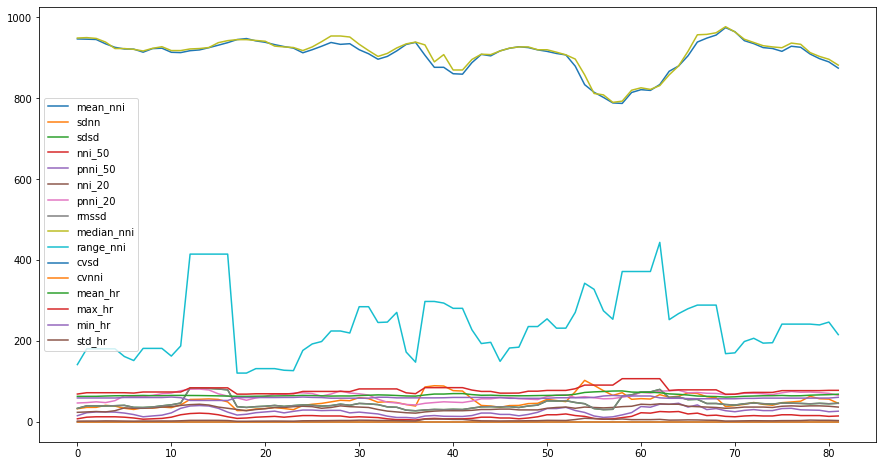

In [112]:
timedomain_df['range_nni'].plot(legend=True, figsize=(15, 8))

<AxesSubplot:>

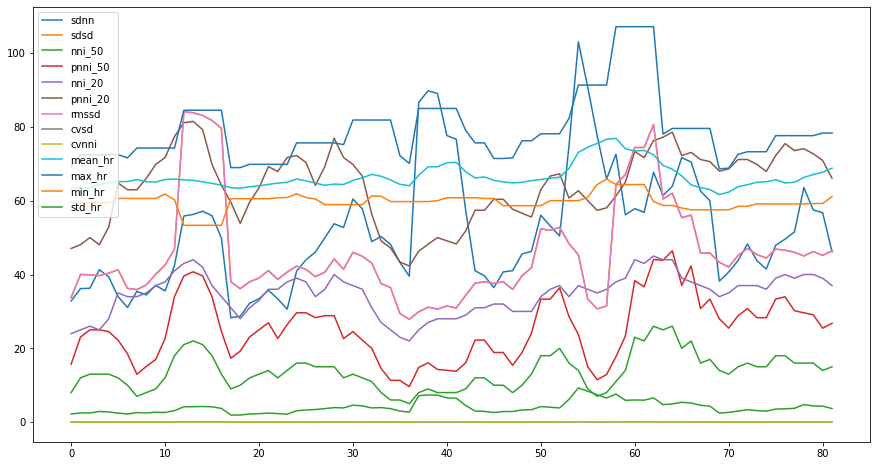

In [149]:
vec = list(timedomain_df.columns)
rm = ['range_nni', 'median_nni', 'mean_nni']
ind = [f for f in vec if f not in rm]

timedomain_df[ind].plot(legend=True, figsize=(15, 8))


<AxesSubplot:>

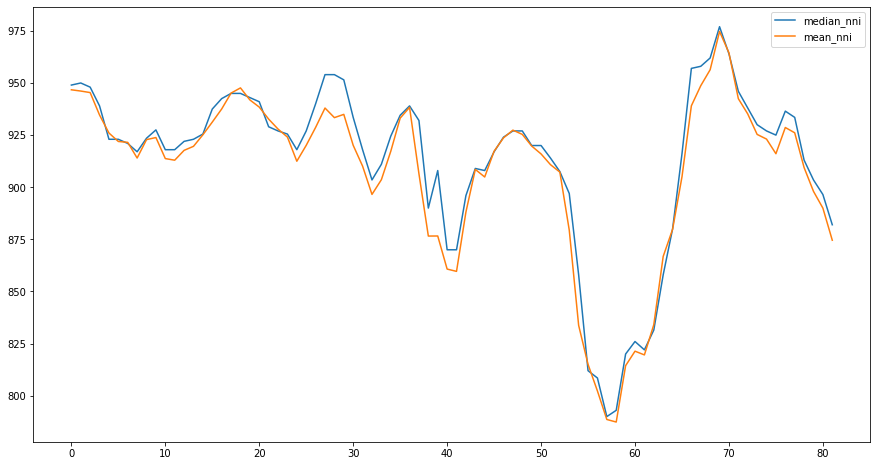

In [111]:
timedomain_df[['median_nni', 'mean_nni']].plot(legend=True, figsize=(15, 8))

<AxesSubplot:>

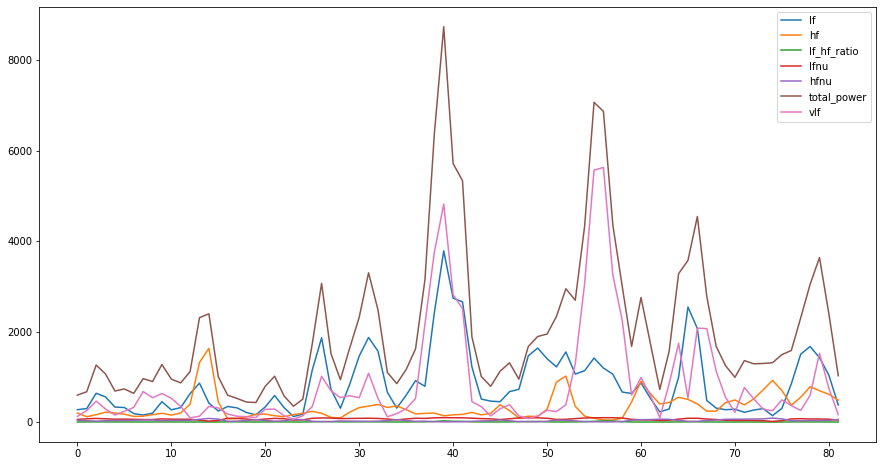

In [108]:
frequency_df.plot(legend=True, figsize=(15, 8))
